In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from arch import arch_model
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Read Futures Contract on the Yen-Dollar Exchange Rate Data
yen_futures = pd.read_csv(Path("Data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)

# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]

# Show Data
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

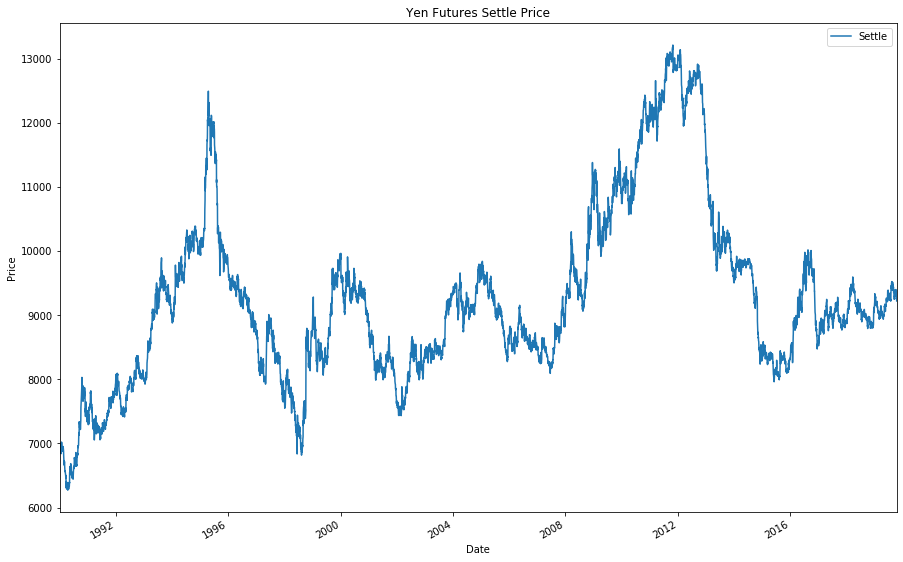

In [3]:
# Plot Settle Column
yen_futures["Settle"].plot(figsize=(15,10),title="Yen Futures Settle Price", legend="Settle").set(xlabel='Date', ylabel='Price');

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [4]:
# Apply Hodrick-Prescott Filter
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [5]:
# Create DataFrame of Settle Price
new_df = pd.DataFrame(yen_futures["Settle"])

# Add Noise to New DataFrame
new_df["Noise"] = settle_noise

# Add Trend to New DataFrame
new_df["Trend"] = settle_trend

# Show DataFrame
new_df

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


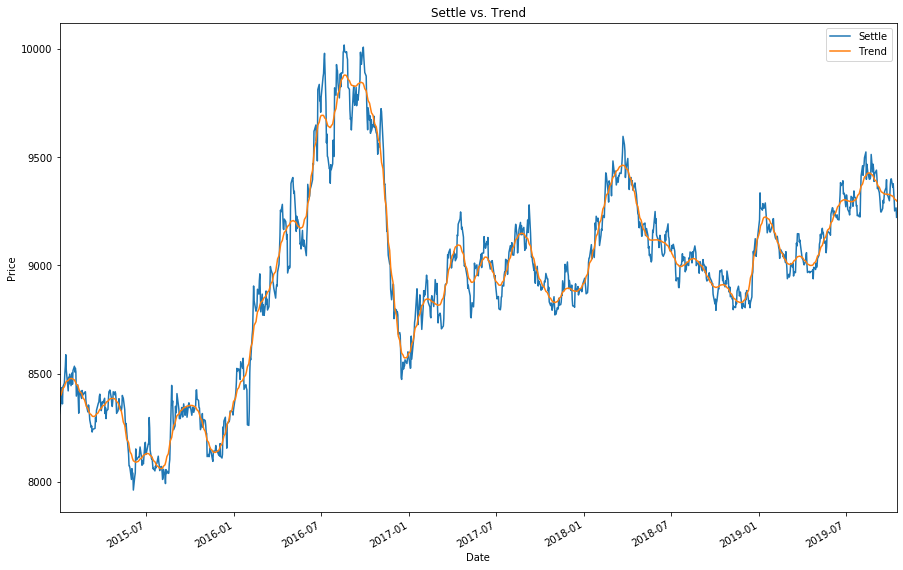

In [6]:
settle_trend = new_df.loc["2015-01-01":, :]

# Plot Settle Price vs. Trend
settle_trend[["Settle", "Trend"]].plot(figsize=(15,10),title="Settle vs. Trend").set(xlabel='Date', ylabel='Price');

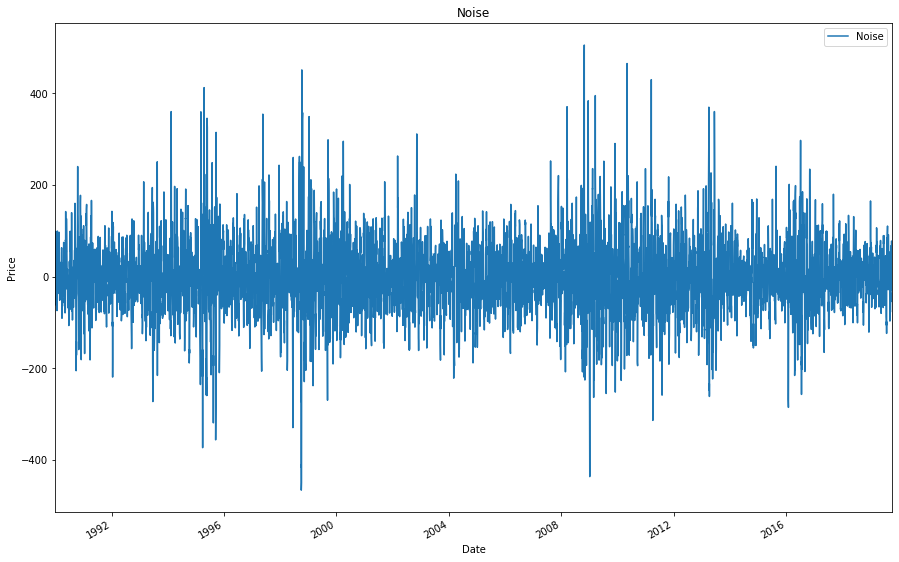

In [7]:
# Plot Settle Noise
new_df["Noise"].plot(figsize=(15,10),title="Noise", legend="Noise").set(xlabel='Date', ylabel='Price');

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [8]:
# Create Returns Off Percent Change of Settle Price
returns = (yen_futures[["Settle"]].pct_change() * 100)

# Replace -inf Values with np.nan"s
returns = returns.replace(-np.inf, np.nan).dropna()

# Show DataFrame
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [9]:
# Instantiate ARMA Model
model = ARMA(returns.values, order=(2,1))

# Fit Model
results = model.fit()

In [10]:
# Output Model Summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 05 Jan 2021   AIC                          15798.142
Time:                        15:13:08   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3061      1.277     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.2565           +0.0000j          157.2565            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

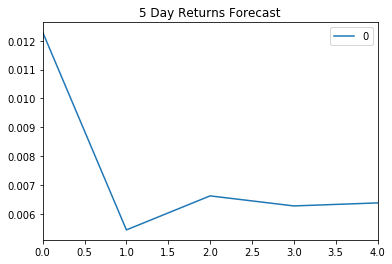

In [11]:
# Plot 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast");

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [12]:
# Instantiate ARIMA Model
model = ARIMA(new_df['Settle'], order=(5, 1, 1))

# Fit Model
results = model.fit()

/Users/gregoryrash/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/gregoryrash/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [13]:
# Output Model Summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 05 Jan 2021   AIC                          83905.238
Time:                        15:13:09   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3786j            2.3408           -0.1002
AR.2            1.8917           +1.3786j            2.3408            0.1002
AR.3           -2.2699           -3.0207j            3.7786           -0.3526
AR.4           -2.2699           +3.0207j            3.7786            0.3526
AR.5          -11.0652           -0.0000j           11.0652           -0.5000
MA.1            3.3648           +0.0000j            3.3648            0.0000
-----------------------------------------------------------------------------
"""

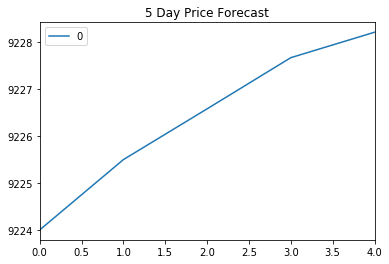

In [14]:
# Plot 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast");

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [15]:
# Instantiate GARCH Model
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit Model
res = model.fit(disp="off")

In [16]:
# Output Model Summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, Jan 05 2021   Df Residuals:                     7510
Time:                        15:13:10   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

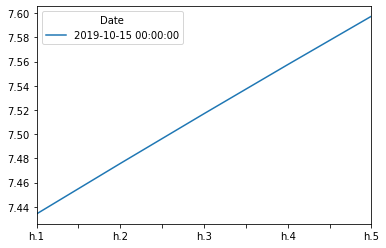

In [17]:
# Find Last Day of Dataset
last_day = returns.index.max().strftime('%Y-%m-%d')

# Establish Forecast Horizon
forecast_horizon = 5

# Start Forecast
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)

# Annualize Forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)

# Transpose Forecast
final = intermediate.dropna().T

# Plot the final forecast
final.plot();

---

# Conclusions

In [18]:
# Specify Output Location 
output_file_location = "../Conclusions/conclusions.txt"

# Write Observable Trends to Text File
with open(output_file_location, "w",) as txtfile:
    txtfile.write(f"""Conclusions
    
1. Based on your time series analysis, would you buy the yen now?

Then Yen is forecasted to increase in price over the next five days, therefore, I would buy then yen now. 

2. Is the risk of the yen expected to increase or decrease?

The risk of the yen is expected to increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?

Based on evaluating the p-values outputted from the models, I would not feel confident using these models for trading.
""")